In [1]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2

import time
import numpy as np

class Timer:  # @save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        if not self.times: return 0.0 # 防止除以0
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [2]:
# Vectorization will accelerate your code
n = 10000
a = torch.ones([n])
b = torch.ones([n])

c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
print(f'{timer.stop():.5f} sec')

timer.start()
d = a + b
f'{timer.stop():.5f} sec' 

0.31447 sec


'0.00000 sec'

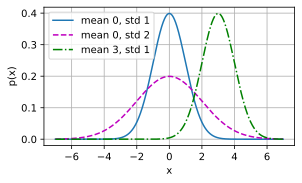

In [3]:
# normal distribution

from d2l import torch as d2l
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x- mu)**2)

x = np.arange(-7,7,0.01)
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
    ylabel='p(x)', figsize=(4.5, 2.5),
    legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

# 1. Linear Regression model implementation

features: tensor([-1.7316,  0.0921]) 
label: tensor([0.4246])


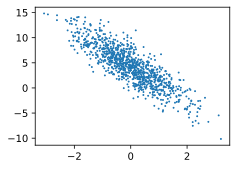

In [4]:
# LR (linear regression) implementation: y = Xw + b
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w))) # col: num_examples, row: len(w)
    y = torch.matmul(X, w) + b # mat-mat product
    y += torch.normal(0, 0.01, y.shape) # adding some offset
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000) # generate 1000 samples & labels
print('features:',features[0],'\nlabel:',labels[0])

d2l.set_figsize()
d2l.plt.scatter(features[:,(1)].detach().numpy(),labels.detach().numpy(),1);

In [5]:
# Split the samples into "bite-size" to feed model
import random
def data_iter(batch_size, features,labels):
    num_examples= len(features)
    indices= list(range(num_examples))
    
    # samples are randomly feed in, no specific pattern of sequence
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        batch_indices= torch.tensor(
            indices[i:min(i+ batch_size,num_examples)])
        yield features[batch_indices],labels[batch_indices]

batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.1814, -0.0410],
        [ 0.8520,  0.8530],
        [-1.1241,  1.3655],
        [-1.2216, -1.4559],
        [ 1.0013,  0.4207],
        [ 0.7445,  1.0547],
        [ 1.4379,  0.0951],
        [-1.7336,  3.2007],
        [ 0.1876, -0.3034],
        [-0.0610,  1.1689]]) 
 tensor([[  3.9848],
        [  3.0058],
        [ -2.7049],
        [  6.6929],
        [  4.7756],
        [  2.1234],
        [  6.7653],
        [-10.1493],
        [  5.6163],
        [  0.0930]])


In [6]:
# Initialize these parameters
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# Now we need to update these parameters
# Every round of update, we need to calculate its grad of the loss function
# So that the model can find the "decreasing grad" way to learn
# In the end, the loss function of the model will decrease = prediction is more accurate
# Now, let's define a LR model
def LRM(X,w,b):
    return torch.matmul(X,w) + b

# Define loss function
def squared_loss(y_pred,y): 
    return (y_pred - y.reshape(y_pred.shape))**2 /2

# Define optimizer: renew the parameters
def sgd(params, lr, batch_size):
    with torch.no_grad(): # the grad of this part is not needed
        for param in params:
            param -= lr*param.grad / batch_size
            param.grad.zero_()

# Train the LRM
lr = 0.03
epochs = 3
net = LRM
loss = squared_loss
for epoch in range(epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.030831
epoch 2, loss 0.000106
epoch 3, loss 0.000049


In [7]:
print(f'w estimate error: {true_w - w.reshape(true_w.shape)}')
print(f'b estimate error: {true_b - b}')

w estimate error: tensor([-0.0004, -0.0004], grad_fn=<SubBackward0>)
b estimate error: tensor([0.0002], grad_fn=<RsubBackward1>)


In [8]:
# Exercise2: Establish a model for the relationship between voltage and current.

import torch
# 1. Let R = 5.0 Ω
true_R = 5.0
I = torch.randn(100, 1) * 10  # Simulate 100 current observations
V = I * true_R + torch.randn(100, 1) * 0.5  # V = I*R + noise

# 2. Initialize param (randomly)
R_hat = torch.randn(1, requires_grad=True) 

# 3. Training
lr = 0.001
for epoch in range(200):
    V_pred = I * R_hat           
    loss = ((V_pred - V)**2).mean() # squared_loss
    
    loss.backward()              # calculate the grad
    with torch.no_grad():
        R_hat -= lr * R_hat.grad # 更新参数
        R_hat.grad.zero_()       # 梯度清零
        
    if epoch % 40 == 0:
        print(f'Epoch {epoch}: Estimated R = {R_hat.item():.5f}')

print(f'\nR_predicted: {R_hat.item():.5f}, R_real: {true_R}')

Epoch 0: Estimated R = 1.95791
Epoch 40: Estimated R = 4.99010
Epoch 80: Estimated R = 4.99248
Epoch 120: Estimated R = 4.99248
Epoch 160: Estimated R = 4.99248

R_predicted: 4.99248, R_real: 5.0


$I(Intensity) = \frac{c1}{\lambda^5 \cdot (e^{\frac{c2}{\lambda \cdot T}} - 1)}$

In [9]:
# Exercise3: etermine an object's temperature based on its spectral energy density using Planck's Law

import torch

# 1. Simulate samples
wavelengths = torch.linspace(0.1, 3.0, 100) # split out 100 samples from 0.1~3μ

def planck_law_stable(wavelength, T):
    if not isinstance(T, torch.Tensor): # make sure T currently is a tensor
        T = torch.tensor(float(T))
    c1 , c2 = 1.0, 14.4
    T = torch.clamp(T, min=0.1)  # make sure T  ∈ [0.1, ∞)
    
    exponent = c2 / (wavelength * T)
    exponent = torch.clamp(exponent, max=80) 
    
    den = (wavelength**5) * (torch.exp(exponent) - 1.0) + 1e-10 # add 1e-10 to make sure denominator ≠ 0
    return c1 / den

true_T_scaled = torch.tensor(5.0) 
intensity_obs = planck_law_stable(wavelengths, true_T_scaled) + torch.randn(100) * 0.01

# 2. initialize params (3.0 represents 3000K)
T_hat_scaled = torch.tensor([3.0], requires_grad=True)


# 3. Train
opt = torch.optim.Adam([T_hat_scaled], lr=0.01)
for i in range(2001):
    intensity_pred = planck_law_stable(wavelengths, T_hat_scaled)
    loss = torch.mean((intensity_pred - intensity_obs)**2)
    opt.zero_grad()
    loss.backward()
    opt.step() # T_hat_scaled -= lr * T_hat_scaled.grad & .grad.zero()
    
    if i % 200 == 0:
        print(f'epoch {i}: Estimated T = {T_hat_scaled.item()*1000:.2f}K, Loss = {loss.item():.6f}')

print(f'\nFinal T: {T_hat_scaled.item()*1000:.2f}K')
print(f'Real T: {true_T_scaled.item()*1000:.2f}K')

epoch 0: Estimated T = 3010.00K, Loss = 0.001872
epoch 200: Estimated T = 4989.45K, Loss = 0.000105
epoch 400: Estimated T = 4999.69K, Loss = 0.000105
epoch 600: Estimated T = 4999.69K, Loss = 0.000105
epoch 800: Estimated T = 4999.69K, Loss = 0.000105
epoch 1000: Estimated T = 4999.69K, Loss = 0.000105
epoch 1200: Estimated T = 4999.69K, Loss = 0.000105
epoch 1400: Estimated T = 4999.69K, Loss = 0.000105
epoch 1600: Estimated T = 4999.69K, Loss = 0.000105
epoch 1800: Estimated T = 4999.69K, Loss = 0.000105
epoch 2000: Estimated T = 4999.69K, Loss = 0.000105

Final T: 4999.69K
Real T: 5000.00K


# 2. LRM implementation(Lite)

In [10]:
# 1. Simulate the samples: y = Xw + b(find the best w & b)
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

# Load samples
def load_array(data_arrays, batch_size, is_train=True): 
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)
next(iter(data_iter))


# 2. Define model
from torch import nn
net = nn.Sequential(nn.Linear(2, 1))

net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)
loss = nn.MSELoss() # mean squared_loss
opt = torch.optim.SGD(net.parameters(), lr=0.03) # Stochastic Gradient Descent

# 3. Train
num_epochs = 6
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        opt.zero_grad()
        l.backward()
        opt.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

w = net[0].weight.data
print('w estimate offset：', true_w- w.reshape(true_w.shape))
b = net[0].bias.data
print('b estimate offset：', true_b- b)

epoch 1, loss 0.000168
epoch 2, loss 0.000101
epoch 3, loss 0.000101
epoch 4, loss 0.000101
epoch 5, loss 0.000100
epoch 6, loss 0.000101
w estimate offset： tensor([ 0.0009, -0.0005])
b estimate offset： tensor([-0.0008])


# 3. Softmax regression

$$\partial_{o_j} l(\mathbf{y}, \hat{\mathbf{y}}) = \text{softmax}(\mathbf{o})_j - y_j$$
$$\operatorname{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}$$

In [11]:
# Image classification data set (eg. MNIST)
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
d2l.use_svg_display()

# Convert image data from PIL type to 32-bit floating-point format (ToTensor)
# divide by 255 to ensure all pixel values are between 0 and 1.
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST( root="./data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST( root="./data", train=False, transform=trans, download=True)

In [12]:
print(len(mnist_train), len(mnist_test))
print(mnist_train[0][0].shape)

60000 10000
torch.Size([1, 28, 28])


In [13]:
# Now we know each image is grayscale(1) and is 28*28 px
# define a function to identify the category by index
def get_fashion_labels(labels):
    txt_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [txt_labels[int(i)] for i in labels]

def show_img(imgs, num_rows, num_cols, titles = None, scale = 1.5):
    figsize = (num_cols*scale, num_rows*scale) # measure the total space to display all img 
    # _ is actually fig, but we won't use it here(if u removed it, the program will pick the wrong attribute)
    _, axes = d2l.plt.subplots(num_rows,num_cols,figsize = figsize) 
    axes = axes.flatten() # turns the matrix to a 1-dim matrix

    # zip will make axes and imgs as a pair 
    # enumerate will count the numbers of these pairs
    for i, (ax, img) in enumerate(zip(axes,imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes # numpy array

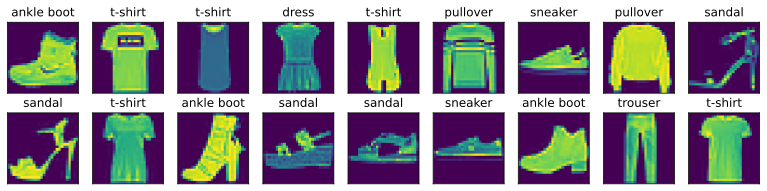

In [14]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_img(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_labels(y));

In [15]:
batch = 256
def get_dataloader_workers():
    return 4 # Using 4 processes to read data.

train_iter = data.DataLoader(mnist_train,batch,shuffle=True,
                             num_workers=get_dataloader_workers())
timer = d2l.Timer()
for X,y in train_iter:
    continue
print(f'{timer.stop():.2f} sec')

def load_data_fashion_mnist(batch_size, resize=None): 
    # 1. laod the dataset into Memory
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    
    # 2. load the datasets
    mnist_train = torchvision.datasets.FashionMNIST( root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST( root="../data", train=False, transform=trans, download=True)
    
    # 3. build DataLoader
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=get_dataloader_workers()))
    
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break # break after traversed the first batch

13.64 sec
torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


### Softmax regression implementation

In [16]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

num_inputs = 784 # 28 * 28 px
num_outputs = 10 # 10 categories
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
print(X.sum(0, keepdim=True), X.sum(1, keepdim=True))

def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition # broadcasting involved

X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
print(X_prob, X_prob.sum(1))

tensor([[5., 7., 9.]]) tensor([[ 6.],
        [15.]])
tensor([[0.4467, 0.0688, 0.2350, 0.1443, 0.1052],
        [0.0308, 0.1619, 0.3722, 0.0304, 0.4047]]) tensor([1., 1.])


In [17]:
# define the model 
def net(X): 
    return softmax(torch.matmul(X.reshape((-1,W.shape[0])),W) + b)

y = torch.tensor([0,2])
y_hat = torch.tensor([[.1, .3, .6] , [.3, .2, .5]]) 
print(y_hat[[0,1],y])


tensor([0.1000, 0.5000])


Cross-Entropy loss: $$l(\mathbf{y}, \mathbf{\hat{y}}) = - \sum_{i=1}^{n} y_i \log \hat{y}_i$$

In [18]:
# define loss function (Cross-EntropyLoss)
# if the loss is tending to 0: it means the model is optimizing
def cross_entropy(y_hat, y):
    return- torch.log(y_hat[range(len(y_hat)), y])
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [19]:
def accuracy(y_hat, y): 
    # calculate the number of correct prediction 
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

# See if the sum of correct prediction / sum of comparison is tending to 1 or not 
# if yes, then it tells us the model is accurate
print(accuracy(y_hat, y)/len(y))

0.5


In [20]:
# now we can define a model to evaluate the accuracy of model 
def eval_accuracy(net, data_iter):
    # using isinstance to chk is net a Pytorch model or not
    if isinstance(net, torch.nn.Module): 
        # if yes: activate model's evaluation mode
        net.eval() 

    # define metric to initialize Accumulator to accept two variables
    metric = Accumulator(2)  # define 2 variables to store total correct prediction & total prediction 
    
    # We dont need the grad while accumulating the correct rate
    with torch.no_grad(): 
        # for each batch: 
        for X,y in data_iter:
            # sum of correct predictions stores in metric[0]
            # sum of the whole predictions stores in metric[1]
            metric.add(accuracy(net(X),y),y.numel()) 
        return metric[0] / metric[1] # return the score

class Accumulator: 
    def __init__(self, n):
        self.data = [.0]*n # initialize how many value to process, here is n = 2

    def add(self, *args):
        self.data = [a + float(b) for a,b in zip(self.data,args)]

    def reset(self): 
        self.data = [0,0] * len(self.data)

    def __getitem__(self,idx):
        return self.data[idx]

eval_accuracy(net,test_iter)

0.0498

In [21]:
# Train
def train_epoch_SM(net,train_iter, loss, updater): 
    if isinstance(net, torch.nn.Module):  #chk is net a pytorch model
        net.train() # if yes: start training

    metric = Accumulator(3) # initialize metric as a Accumulator that accept 3 variables
    for X,y in train_iter: 
        y_hat = net(X)      # in the training loop: y_hat is the result of prediction
        l = loss(y_hat,y)   # l will call loss funct to chk the result

        if isinstance(updater, torch.optim.Optimizer):  # is updater a pytorch optimizer
            updater.zero_grad()  # clear all the grad value in updater
            l.mean().backward()  # find the grad of l's mean
            updater.step()       # update the parameters
        else:
            l.sum().backward()  # if updater is not a pytorch optimizer
            updater(X.shape[0]) # update the parameters (make sure to divide its batch_size(X.shape[0]) to find l's mean)
            
        metric.add(float(l.sum()), accuracy(y_hat,y), y.numel())

    # metric[0] / metric[2]: rate of wrong prediction
    # metric[1]/ metric[2]: rate of correct prediction
    return metric[0] / metric[2], metric[1]/metric[2]

In [22]:
class Animator:  
    # display the graph animation
    # default not setting xlabel,...,ylabel
    # xscale, yscale using a linear scale: +1,+1,...
    # fmt(formats: color + line type): - solid, -- dashed, -. dash-dot, : dotted
    # nrows & ncols = 1: only draw one picture
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        
        if legend is None:
            legend = []

        d2l.use_svg_display()
        # set the whole paper(fig) and axes(axes)
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ] # make sure it is a List
 
        # while presenting the animation, the graph has to be adjust frequentl 
        # so we can set a lambda function to save all the graph info for the next frame
        # now while displaying the next frame, Animator can get the graph info by this function
        self.config_axes = lambda: d2l.set_axes( self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        # initialize X,Y & fmts before drawing the graph
        self.X, self.Y, self.fmts = None, None, fmts

    
    def add(self, x, y):
        if not hasattr(y, "__len__"): # hasattr: has attribute(chk if there's any attr or method exists )
            y = [y] # convert to list
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n

        # construct a bunch of empty list [[],[],...] only for one time(which is at the beginning when X,Y are None)
        # Goal: initialize the list
        if self.X is None: 
            self.X = [[] for _ in range(n)]
        if self.Y is None: 
            self.Y = [[] for _ in range(n)]

        # append the data to the list
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)

        # cla(clear all) to clear the previous frame
        self.axes[0].cla()

        # Redraw everything 
        # plot all historical data points stored in X & Y
        for x_arr, y_arr, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x_arr, y_arr, fmt)
        
        self.config_axes()
        display.display(self.fig) # display the graph
        display.clear_output(wait=True) # clear previous output if the current output is ready

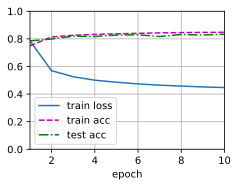

In [23]:
# train
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): 
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1.0],
                        legend=['train loss', 'train acc', 'test acc'])
    
    for epoch in range(num_epochs):
        train_metrics = train_epoch_SM(net, train_iter, loss, updater)
        test_acc = eval_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))

    #  train_metrics have 2 returns: return metric[0] / metric[2], metric[1]/metric[2]
    # train_loss get the first ret, which is the train_loss; train_acc get the second
    train_loss, train_acc = train_metrics

    # if the condition satisfied, it will break the process
    #assert train_loss < 0.5, f"Loss too high: {train_loss}"
    #assert train_acc <= 1 and train_acc > 0.7, f"Acc too low: {train_acc}"
    #assert test_acc <= 1 and test_acc > 0.7, f"Test Acc too low: {test_acc}"

lr = 0.1
def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

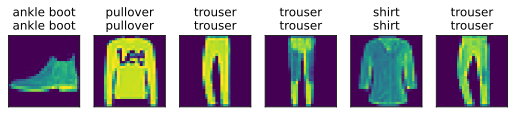

In [24]:
# Test
def predict_ch3(net, test_iter, n=6):  
    for X, y in test_iter:
        break
    
    # 1. 获取真实标签
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [f"{true}\n{pred}" for true, pred in zip(trues, preds)]

    d2l.show_images(X[0:n].reshape((n,28,28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

# 4. Sofmax regression model (Lite)

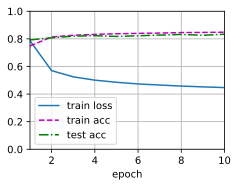

In [29]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

# initialize the model
# Sequential automatically assembles model
# flatten: flaten the 28*28 px img to vector with a length of 28*28 
# Linear: construct a fully-connected nn which input is 784 dimensions, output is 10 dimensionsa
# dimension = vector length / sum of neurons 
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))
def init_weights(m): # define a random number to initialize the model
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01) # normal distribution, std deviation = 0.01


net.apply(init_weights);
loss = nn.CrossEntropyLoss(reduction='none')
opt = torch.optim.SGD(net.parameters(), lr=0.1)

# train
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, opt)